                                                                                                MSC 10-2022

# Filtering

- [**Imports**](#Imports)
- [**Introduction**](#Introduction)
- [**Finite Impulse Response Filters (FIR)**](#Finite-Impulse-Response-Filters-(FIR))
    - [**Mathematics**](#Mathematics)
    - [**Design Methods**](#Design-Method)
        - [**FIR Filter Design in Openseize**](#FIR-Filter-Design-in-Openseize)
        - [**General Cosine Windows**](#General-Cosine-Windows)
        - [**Kaiser Windows**](#Kaiser-Windows)
        - [**Minimax Window Method**](#Minimax-Window-Method)
        - [**Practical Considerations & Recommendations**](#Practical-Considerations-&-Recommendations)
- [**Infinite Impulse Response Filters (IIR)**](#Infinite-Impulse-Response-Filters-(FIR))
    - [**Mathematics**](#Mathematics)
    - [**IIR Filter Design in Openseize**](#IIR-Filter-Design-in-Openseize)
    - [**Transfer Function Coeffecient Formats**](#Transfer-Function-Coeffecient-Formats)
    - [**Practical Considerations & Recommendations**](#Practical-Considerations-&-Recommendations)
- [**Notch Filters**](#Notch-Filters) 
- [**Appendix**](#Appendix)

## Imports

In [85]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from openseize import filtering

## Introduction

This tutorial covers the mathematics, design and application of filters in Openseize. Since this is a deep subject, the tutorial can be approached in two ways. First, readers that are interested in understanding the principles that govern filter design methods, the sections headed by "Mathematics" are a starting point and include references for deeper study. Second, readers who are only interested in the practical implementation of each filter can safely skip these sections but be sure to carefully read the "Practical Considerations and Recommendations" sections.
</br>
</br>
Lastly it is important to remember that there are two stages to filtering data. The first is to design a filter that meets a specific set of design criteria and second to apply the filter to a potentially very large data set. Openseize streamlines these two processes by allowing clients to create filter objects with methods that handle both the filter design and the iterative application of the filter to data that may not fit into RAM. The application of the filter to large data is carried out using the overlap-add method for FIR filters and initial conditioning for IIR filters. This tutorial does not specifically address those algorithms. For details on this iterative implementation of filters, please see the openseize.numerical module. It has detailed documentation on the nitty-gritty of applying filters to large datasets.  

## Finite Impulse Response Filters (FIR)

### Mathematics

A Finite Impulse Response filter is a set of coeffecients $h[n]$ used to weight previous signal samples $x[n]$ to yield each filtered output $y[n]$. This process is called convolution and is written as:
</br>
</br>
<center> $y[n] = \sum \limits_{i=0}^{N} h[i] \ x[n-i] \quad (1)$ </center>

Openseize defaults to using Type I FIR filters which means that that the number of coeffecients in h (also called the filter order) is an even number N=2M and have an initial phase $\phi_0 = 0$. In the literature the number of taps is N + 1 as it includes the 0th order of the filter. <b> The goal is to find a set of finite coeffecients for h such that the amplitude and frequency responses in the frequency domain meet our design criteria </b>. We'll discuss how to do this in the next sections. 

Let's suppose that we want to design a filter that has an amplitude response of:
</br>
</br>
<center> $A_{d}(\theta) = \begin{cases}
                            1 & \theta_1 \leq |\theta| \leq \theta_2 \\
                            0 & otherwise
                       \end{cases} \quad (2)$
</center>

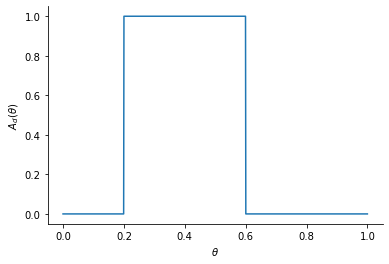

In [147]:
# Example bandpass with 0.2*pi and 0.6*pi cutoff frequencies (here theta is in rads/sec)
theta1 = 0.2
theta2 = 0.6

thetas = np.linspace(0, 1, 1000)
amplitudes = (thetas >= 0.2) & (thetas <= 0.6)
fig, ax = plt.subplots()
ax.plot(thetas, amplitudes)
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$A_d(\theta)$')
plt.show()

The ideal frequency response of Eq. 2 can be written as (proof in appendix):
</br>
</br>
<center>$H^f(\theta) = A(\theta)\ e^{-i\theta N/2} \quad (3) $ </center>

Here we see two terms, the amplitude response term $A(\theta)$ and the phase delay of the response $e^{-i\theta N/2}$. Thus the phase of a type I FIR is a constant equal to half the filters order N/2. This is important. FIR filters delay the output y[n] by 1/2 the filter order. 

Our goal is still to find $h[n]$, we now have the ideal frequency response $H^f(\theta)$ so we can use the inverse Fourier transform to to get $h[n]$.
</br>
</br>
<center> $h_d[n] = \frac{1}{2\pi} \int \limits_{-\theta_2}^{\theta_1}e^{i \theta (n-N/2)} d\theta + \frac{1}{2\pi} \int \limits_{\theta_1}^{\theta_2}e^{i \theta (n-N/2)}d\theta \quad (4)$
</br>
</br>
$= \frac{\sin(\theta_2(n-N/2))}{\pi(n-N/2)} - \frac{\sin(\theta_1(n-N/2))}{\pi(n-N/2)} \quad (5)$
</br>
</br>
$= \frac{\theta_2}{\pi}sinc[\frac{\theta_2(n-N/2)}{\pi}]- \frac{\theta_1}{\pi}sinc[\frac{\theta_1(n-N/2)}{\pi}] \quad (6)$

Notice that $h_d[n]$ can have as many terms as we like 10, 100, 100k etc.. Since we can't have an infinite set of filter coeffecients, they coeffecients are truncated so that $0 \leq n \leq N$. Lets build the impulse response for 40 and 80 coeffecients and plot it onto our desired amplitude response.

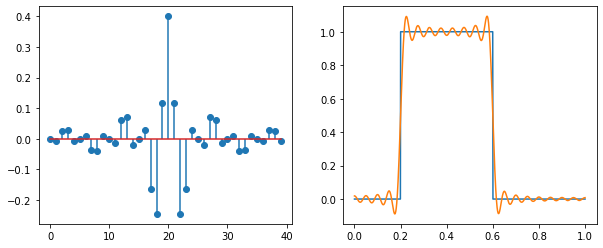

In [157]:
n40 = np.arange(0, 40)
n80 = np.arange(0, 80)

hd_40 = theta2 * np.sinc(theta2 * (n40 - 40/2)) - \
        theta1 * np.sinc(theta1 * (n40 - 40/2))

# see 9.5 for amplitude response
def amplitude_response(h, thetas=np.linspace(0, np.pi, 1000)):
    """ """
    
    M = len(h)//2
    result = []
    for theta in thetas:
        term = 0
        for n in range(0, M+1):
            if n==0:
                term = h[M]
            else:
                term += 2*h[M-n]*np.cos(theta*n)
        result.append(term)
    return result
        
Ad_40 = amplitude_response(hd_40)
    
#Ad_40 = np.abs(np.fft.fft(hd_40, n=512, axis=0))

hd_80 = theta2 * np.sinc(theta2 * (n80 - 80/2)) - \
        theta1 * np.sinc(theta1 * (n80 - 80/2))
Ad_80 = amplitude_response(hd_80)

fig, axarr = plt.subplots(1, 2, figsize=(10,4))
axarr[0].stem(hd_40)
axarr[1].plot(thetas, amplitudes, label=r'$A_d(\theta)$')
f = np.linspace(0,1, len(Ad_80))
axarr[1].plot(f, Ad_80)
plt.show()